In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fitsio
import glob
import emcee
import scipy.optimize as sco

Autocorrelation function pinched from emcee

In [11]:
def acorr(x, axis=0):
    """
    Estimate the autocorrelation function of a time series using the FFT.
    :param x:
        The time series. If multidimensional, set the time axis using the
        ``axis`` keyword argument and the function will be computed for every
        other axis.
    """
    x = np.atleast_1d(x)
    m = [slice(None), ] * len(x.shape)

    # For computational efficiency, crop the chain to the largest power of
    # two if requested.
    n = x.shape[axis]

    # Compute the FFT and then (from that) the auto-correlation function.
    f = np.fft.fft(x-np.mean(x, axis=axis), n=2*n, axis=axis)
    m[axis] = slice(0, n)
    acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
    m[axis] = 0
    return acf / acf[m]

A Squared exponential function

In [50]:
def SE(par, x):
    return par[0] * np.exp(-x**2/(2*par[1]**2))

A QP function

In [49]:
def QP(par, x):
    return par[0] * np.exp( - x**2/(2*par[1]**2) - par[2]**2 * (np.sin(np.pi*x/par[3]))**2 )

Load and plot an example light curve

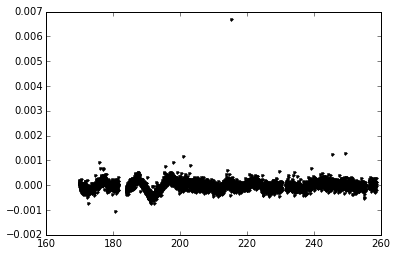

In [20]:
kid = "008311864"
fnames = glob.glob("/Users/ruthangus/.kplr/data/lightcurves/{0}/*".format(kid))
data = fitsio.read(fnames[2])
time = data["TIME"]
flux = data["PDCSAP_FLUX"]
err = data["PDCSAP_FLUX_ERR"]
m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(err)
x = time[m]
med = np.median(flux[m])
y = flux[m]/med - 1
yerr = err[m]/med
plt.plot(x, y, "k.")

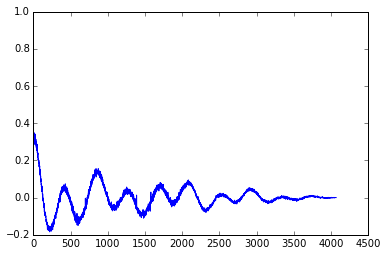

In [43]:
acf = acorr(y)
plt.plot(acf) # plot acf

Plot a squared exponential function

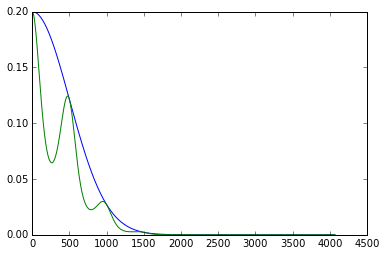

In [45]:
A, l, g, P = .2, 500, 1, 500
se = SE(A, l, np.arange(len(acf)))
qp = QP(A, l, g, P, np.arange(len(acf)))
plt.plot(se)
plt.plot(qp)

Fit the two functions to the ACF

In [51]:
result = sco.minimize(SE, [A, l], args=acf)

ValueError: setting an array element with a sequence.